In [41]:
import os
import sys
import time
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import scipy as sc
from tensorflow import keras

import assay
import calibrate as cal

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
plt.rcParams["font.size"] = 16

import seaborn as sns
sns.set_style('whitegrid', {'grid.color': '0.9'})

In [129]:
# load lambdas and mean predicted fitnesses of test sequence distributions
scale = 0.1
d = np.load('../aav/models/constrained_maxent_scale{}_052722.npz'.format(scale))

# note that lambda in bioRxiv above corresponds to 1 / lambda for us
lambda_l = (1 / d['temperature_l']).astype(int)
meanpredfit_l = d['meanpredfit_l']

In [37]:
# load coverage and sizes of randomized staircase confidence sets (constructed in aav-experiments.ipynb)
fname = '../aav/randomized-staircase-results_2.npz'
d = np.load(fname, allow_pickle='True')
cov_lxt = d['cov_lxt'].item()
avglen_lxt = d['avglen_lxt']
fracinf_lxt = d['fracinf_lxt']
len_lxt = d['len_lxt'].item()
fit_lxt = d['fit_lxt'].item()

In [111]:
# compute mean empirical coverage and mean true fitness per lambda
n_lambda, n_trial = lambda_l.size, 500 
cov_l = np.zeros([n_lambda])
truefit_l = np.zeros([n_lambda])
for l in range(n_lambda):
        cov_l[l] = np.mean([np.mean(cov_lxt[(l, t)]) for t in range(n_trial)])
        truefit_l[l] = np.mean([np.mean(fit_lxt[(l, t)]) for t in range(n_trial)])

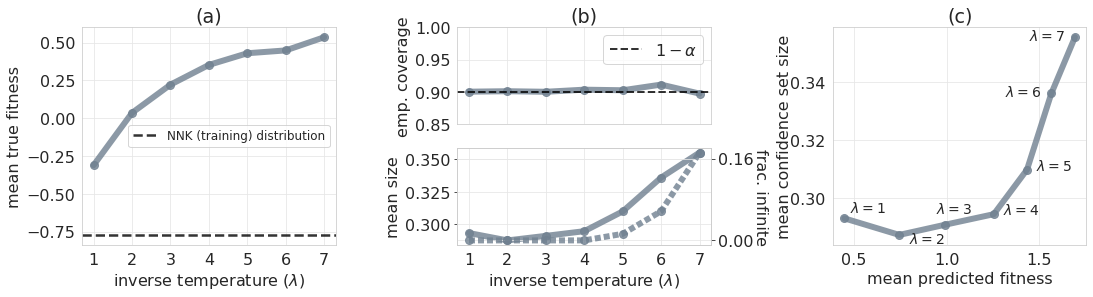

In [132]:
# plot Fig. 5
save_fig = True
fname = '../figures/fig5-aav.pdf'
cmain = 'slategray'

fig = plt.figure(figsize=(18, 4))
gs1 = gridspec.GridSpec(1, 3, figure=fig, wspace=0.48)
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs1[1], hspace=0.25)
ax1 = plt.subplot(gs1[0])
ax21 = plt.subplot(gs2[0])
ax22 = plt.subplot(gs2[1])
ax3 = plt.subplot(gs1[2])

# ===== true fitness =====

nnkmeanfitness = -0.7716402509409155
ax1.plot(lambda_l, truefit_l, '-ob', linewidth=6, markersize=8, alpha=0.8, c=cmain, label='__nolegend__');
ax1.axhline(nnkmeanfitness, linestyle="--", linewidth=2.5, alpha=0.8,
            color='k', label=r'NNK (training) distribution')
ax1.set_xticks(lambda_l);
ax1.set_xticklabels(lambda_l);
ax1.set_ylabel('mean true fitness')
ax1.set_xlabel(r'inverse temperature ($\lambda$)')
ax1.legend(fontsize=12);
ax1.set_title('(a)')

# ===== coverage =====

ax21.plot(lambda_l, cov_l, '-o', linewidth=6, markersize=8,  alpha=0.8, c=cmain, label='__nolegend__');
ax21.set_ylabel('emp. coverage');
ax21.set_xticklabels([])
ax21.set_ylim([0.85, 1]);
ax21.set_yticks([0.85, 0.9, 0.95, 1])
ax21.set_xticks(lambda_l);
ax21.axhline(0.9, linestyle='--', linewidth=2, alpha=0.8, c='k', label=r'$1 - \alpha$');
ax21.legend()
ax21.set_title('(b)')

# ===== confidence set sizes =====
fmax = 8.798749497001769
fmin = -7.530085215864544
frange = fmax - fmin

navglen_lxt = avglen_lxt / frange  # report average size as fraction of total range of fitness values
navglen_l = np.nanmean(navglen_lxt, axis=1)
ax22.plot(lambda_l, navglen_l, '-o', linewidth=6, markersize=8, alpha=0.8, c=cmain);
ax22.set_ylabel('mean size');
ax22.set_xticks(lambda_l);
ax22.set_xticklabels(lambda_l);
ax22.set_xlabel(r'inverse temperature ($\lambda$)')

# fraction of confidence sets with infinite size
ax22inf = ax22.twinx()
ax22inf.plot(lambda_l, np.mean(fracinf_lxt, axis=1), '--o', dashes=(1, 0.5), linewidth=6, markersize=8, alpha=0.8, c=cmain);
ax22inf.set_ylabel('frac. infinite', rotation=270, labelpad=14);
ax22inf.set_yticks([0, 0.16]);


# ===== trade-off with certainty =====

ax3.plot(meanpredfit_l, navglen_l, '-o', linewidth=6, markersize=8, alpha=0.8, c=cmain);
ax3.set_xlabel('mean predicted fitness');
ax3.set_ylabel('mean confidence set size', labelpad=-2);
ax3.set_title('(c)');

xoff = [0.03, 0.05, -0.05, 0.05, 0.05, -0.25, -0.25]
yoff = [0.002, -0.003, 0.004, 0, 0, -0.001, -0.001]
for l, lmbda in enumerate(lambda_l):
    ax3.annotate(r'$\lambda = {}$'.format(lmbda),
                 (meanpredfit_l[l] + xoff[l], navglen_l[l] + yoff[l]), fontsize=14)

if save_fig:
    plt.savefig(fname, dpi=300, bbox_inches='tight')